In [1]:
# Perform the initialization and imports
import sys
import pickle
import re
import os
import csv
import argparse
import math
import pprint

from string import ascii_lowercase
from collections import Counter, defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from Bio import SeqIO, AlignIO
from Bio.SeqRecord import SeqRecord
from Bio.Alphabet import IUPAC
from Bio.Seq import Seq
from Bio.Emboss.Applications import NeedleallCommandline

# Demand Python 3.
if sys.version_info[0] < 3:
    print("Python 3 is required, but you are using Python %i.%i.%i") % (
        sys.version_info[0], sys.version_info[1], sys.version_info[2])
    sys.exit(1)

In [2]:
# Retrieve the specific functions from ind and proteins.py
indels_path="/home/mp/InDelScanner"  # /PATH/TO/InDelScanner
if indels_path not in sys.path:
    sys.path.append(indels_path)
from indels.ind import trim_read, findEnds, endMatch, findGap, gapAlign
from ipynb.fs.defs.F01_Library_diversity import convert_variant_to_dict, single_fraction_enrichment

In [3]:
os.chdir("/mnt/c/Users/Maya/Documents/03_Kinases/code_check")

with open('mek.pickle', 'rb') as f:
    mek = pickle.load(f)

with open('kinases_all_ref.pickle', 'rb') as f:
    all_ref = pickle.load(f)

In [4]:
# Set general restrictions stemming from SpliMLib library design
aa_2 = ['A', 'Δ']
aa_12 = ['A','G','P','Y','D','K','M','V','I','L','F','W']
aa_13 = aa_12 +  ['Δ']
splimlib = {'6': aa_12, '9': aa_12, '11': aa_12, '13': aa_12, '7a': aa_13, '8a': aa_2}

In [5]:
df_all = pd.DataFrame.from_dict(mek).fillna(0).sort_values(by=['high', 'med','low-t'], ascending=False)

## Set up the dataset: collect SpliMLiB variants with >10/5/3 reads in H/M/L gates

In [6]:
df_all.head()

,high,med,low-t
6L/7aI/8aA/9L/11F/13M,1185.0,33.0,6.0
6F/7aP/9W/11L/13M,903.0,81.0,15.0
6L/7aF/9L/11I/13I,899.0,2.0,8.0
6A/7aI/8aA/9L/11L/13I,893.0,3.0,19.0
6W/7aI/9F/11L/13V,880.0,34.0,20.0


In [7]:
wt_short = '6P/9I/11L/13P'
wt = {'6': 'P', '7a': 'Δ', '8a': 'Δ', '9': 'I', '11': 'L', '13': 'P'}

In [8]:
df_all.loc[(lambda df_all: df_all['high'] >= 10) or (lambda df_all: df_all['med'] >= 5) or (lambda df_all: df_all['low-t'] >= 3), :].describe()

,high,med,low-t
count,36702.000000,36702.000000,36702.000000
mean,123.726473,10.460384,11.073021
std,91.317521,14.809720,9.908472
min,10.000000,0.000000,0.000000
25%,62.000000,0.000000,5.000000
50%,105.000000,3.000000,10.000000
75%,161.000000,17.000000,15.000000
max,1185.000000,232.000000,453.000000


Select all variants that appear in the Venn circle diagram: 10+ reads in high gate OR 5+ in medium OR 3+ in low gate.

In [9]:
l = df_all.loc[lambda df: df['low-t'] >= 3, :]
m = df_all.loc[lambda df: df['med'] >= 5, :]
h = df_all.loc[lambda df: df['high'] >= 10, :]

In [10]:
all_filtered_df = pd.concat([h, m, l], join='outer')

In [11]:
wt_short = '6P/9I/11L/13P'
wt = {'6': 'P', '7a': 'Δ', '8a': 'Δ', '9': 'I', '11': 'L', '13': 'P'}

Add Hamming distance for variants vs WT in this dataset.

In [12]:
# hamming distance = 0 if the aa matches at all positions
def hamming_distance(s1, s2, splimlib):
    d = 0
    if (len(s1) != len(splimlib)) or (len(s2) != len(splimlib)):
        d += 1

    for p in splimlib.keys():
        if s1[p] != s2[p]:
            d += 1
    return d

In [13]:
H_dist = {}
for n in all_filtered_df.index:
    s1 = convert_variant_to_dict(n)
    H_dist[n] = hamming_distance(wt, s1, splimlib)
    
all_filtered_df['Hamming'] = pd.Series(H_dist)

Check that we are only considering variants that fit the expected SpliMLiB pattern.

In [14]:
def is_variant_in_expected_set(m_by_pos, splimlib):
    for k, a in m_by_pos.items():
        if k not in splimlib.keys():
            return False
        elif a not in splimlib[k]:
            return False
    return True

In [15]:
mutations_all_positions = {}
position_order = ['6', '7a', '8a', '9', '11', '13']
expected = {}

for n in all_filtered_df.index:
    s1 = convert_variant_to_dict(n)
    expected[n] = is_variant_in_expected_set(s1, splimlib)
    aa_seq = [p + s1[p] for p in position_order]
    mutations_all_positions[n] = '/'.join(aa_seq)


In [16]:
all_filtered_df['variants'] = pd.Series(mutations_all_positions)

In [17]:
all_filtered_df['in_lib'] = pd.Series(expected)

In [18]:
all_filtered_df.shape

(676389, 6)

In [19]:
df_splimlib = all_filtered_df.loc[all_filtered_df['in_lib'] == True].drop(columns=['in_lib']).drop_duplicates()

In [20]:
df_splimlib.describe()

,high,med,low-t,Hamming
count,505957.000000,505957.000000,505957.000000,505957.000000
mean,9.184081,5.964195,13.308643,5.085193
std,40.385787,11.474580,8.701844,0.791608
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,7.000000,5.000000
50%,0.000000,0.000000,12.000000,5.000000
75%,0.000000,8.000000,18.000000,6.000000
max,1185.000000,165.000000,95.000000,6.000000


In [21]:
df_splimlib.head()

,high,med,low-t,Hamming,variants
6L/7aI/8aA/9L/11F/13M,1185.0,33.0,6.0,6,6L/7aI/8aA/9L/11F/13M
6F/7aP/9W/11L/13M,903.0,81.0,15.0,4,6F/7aP/8aΔ/9W/11L/13M
6L/7aF/9L/11I/13I,899.0,2.0,8.0,5,6L/7aF/8aΔ/9L/11I/13I
6A/7aI/8aA/9L/11L/13I,893.0,3.0,19.0,5,6A/7aI/8aA/9L/11L/13I
6W/7aI/9F/11L/13V,880.0,34.0,20.0,4,6W/7aI/8aΔ/9F/11L/13V


In [22]:
df_splimlib.tail()

,high,med,low-t,Hamming,variants
6P/7aG/8aA/9I/11Y/13K,0.0,0.0,3.0,4,6P/7aG/8aA/9I/11Y/13K
6I/7aG/9D/11G/13V,0.0,0.0,3.0,5,6I/7aG/8aΔ/9D/11G/13V
6Y/7aK/8aA/9G/11Y/13I,0.0,0.0,3.0,6,6Y/7aK/8aA/9G/11Y/13I
6Y/7aW/9I/11G/13I,0.0,0.0,3.0,4,6Y/7aW/8aΔ/9I/11G/13I
6I/7aI/9A/11F/13V,0.0,0.0,3.0,5,6I/7aI/8aΔ/9A/11F/13V


### Examine the combined enrichment distributions

In [23]:
# convert the read count data into percentages
df = df_splimlib.copy(deep=True)
df['total_reads'] = df[['high', 'med', 'low-t']].sum(axis=1)
df[['high_per', 'med_per', 'low_per']] = df[['high', 'med', 'low-t']].div(df['total_reads'], axis=0).mul(100).round(3)

In [24]:
# sort the variants
df = df.sort_values(by=['high_per', 'med_per','low_per'], ascending=False).reset_index(drop=True)

In [25]:
df.rename(columns = {'index':'variant'}, inplace = True)

In [26]:
df.head()

,high,med,low-t,Hamming,variants,total_reads,high_per,med_per,low_per
0,537.0,0.0,0.0,6,6V/7aP/8aA/9F/11V/13W,537.0,100.0,0.0,0.0
1,524.0,0.0,0.0,6,6V/7aP/8aA/9F/11I/13W,524.0,100.0,0.0,0.0
2,480.0,0.0,0.0,6,6K/7aI/8aA/9L/11I/13K,480.0,100.0,0.0,0.0
3,456.0,0.0,0.0,5,6A/7aL/8aΔ/9F/11I/13V,456.0,100.0,0.0,0.0
4,449.0,0.0,0.0,6,6F/7aI/8aA/9L/11I/13M,449.0,100.0,0.0,0.0


Let's have a look at the WT values.

In [27]:
wt_short = '6P/7aΔ/8aΔ/9I/11L/13P'
wt = {'6': 'P', '7a': 'Δ', '8a': 'Δ', '9': 'I', '11': 'L', '13': 'P'}
df.loc[df['variants'] == wt_short]

,high,med,low-t,Hamming,variants,total_reads,high_per,med_per,low_per
37020,51.0,36.0,34.0,0,6P/7aΔ/8aΔ/9I/11L/13P,121.0,42.149,29.752,28.099


In [28]:
df.loc[df['variants'] == '6P/7aΔ/8aΔ/9A/11A/13P']

,high,med,low-t,Hamming,variants,total_reads,high_per,med_per,low_per
209208,0.0,6.0,20.0,2,6P/7aΔ/8aΔ/9A/11A/13P,26.0,0.0,23.077,76.923


Next let's check the relationship between the high gate cutoff and the number of active variants.

In [29]:
from collections import OrderedDict

In [30]:
cutoff_choices = OrderedDict()
for i in range(5, 201):
    cutoff_choices[i] = len(df.loc[df['high'] >= i])


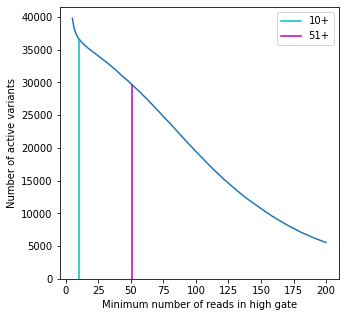

In [31]:
fig, ax = plt.subplots(1, 1,figsize=(5, 5))
ax.plot(cutoff_choices.keys(), cutoff_choices.values())

y_lims = ax.get_ylim()
ax.set_ylim([0, y_lims[1]])
plt.axvline(x=10, ymin=0, ymax= cutoff_choices[10]/y_lims[1], color='c', label='10+')
plt.axvline(x=51, ymin=0, ymax= cutoff_choices[51]/y_lims[1], color='m', label='51+')
ax.legend()

ax.set_ylabel('Number of active variants')
ax.set_xlabel('Minimum number of reads in high gate')

plt.show()

In [32]:
cols = ['mediumseagreen', 'gold', 'salmon']

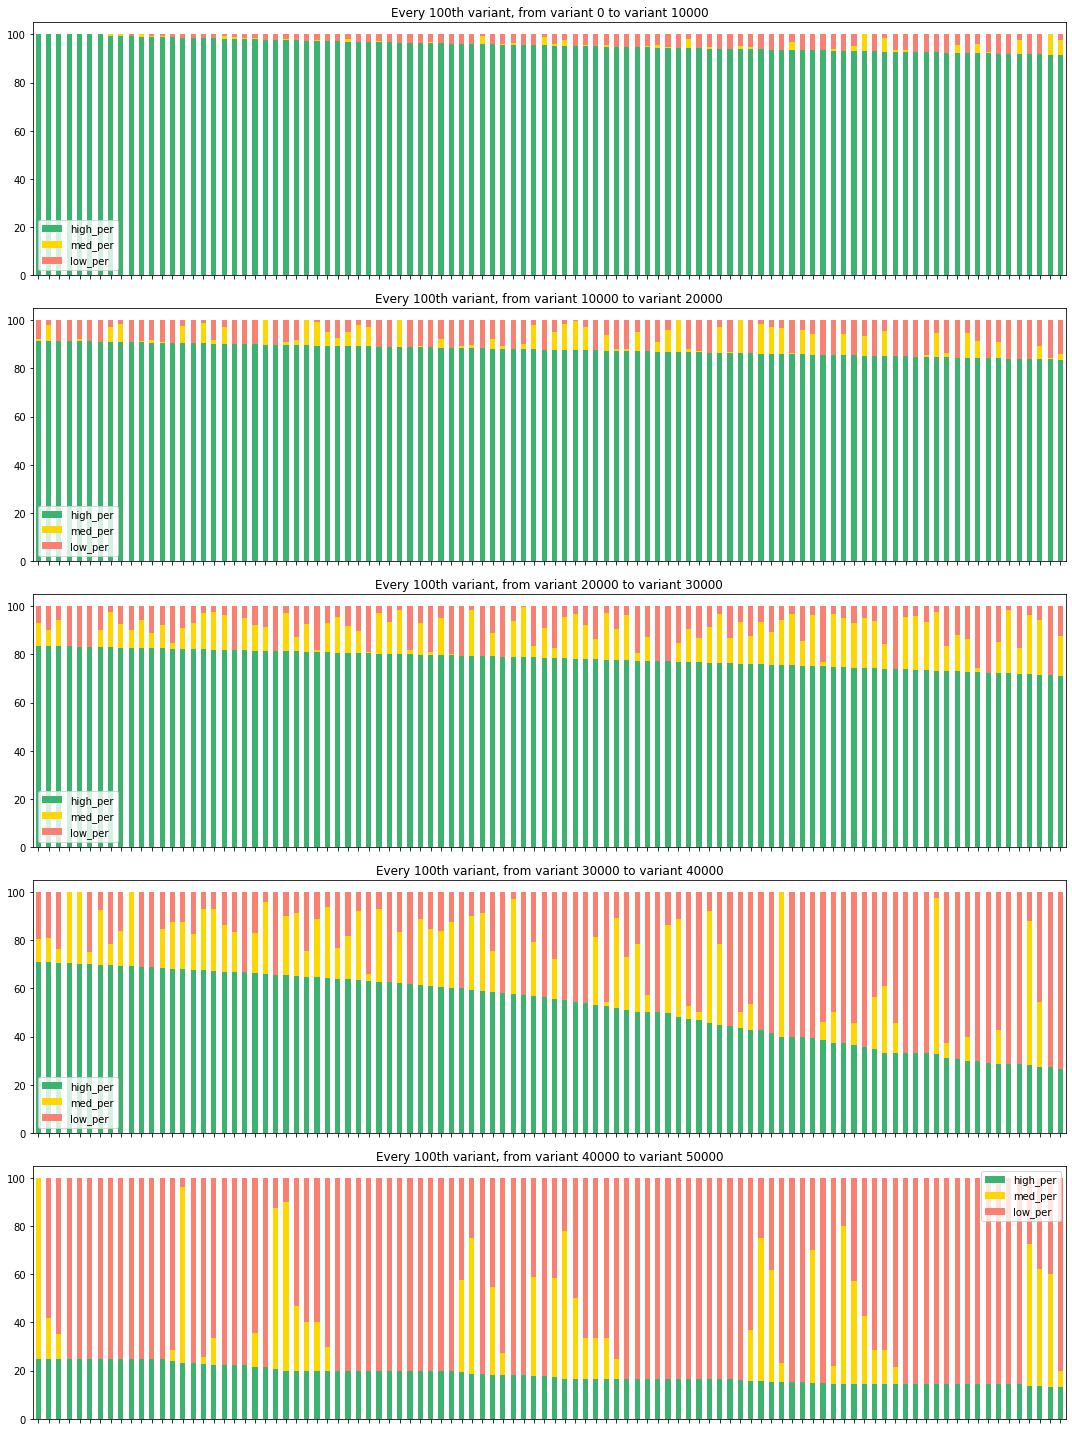

In [33]:
split = 10000
n=5

fig, axes = plt.subplots(n, 1,figsize=(15,4*n))

for p in range(len(axes)):
    df[['high_per', 'med_per', 'low_per']].iloc[p*split:(p+1)*split:100].plot.bar(stacked=True, ax=axes[p], color = cols)
    axes[p].axes.get_xaxis().set_ticklabels([])
    title = 'Every 100th variant, from variant ' + str(p*split) + ' to variant ' + str((p+1)*split)
    axes[p].set_title(title, position=(0.5, 0.9))


plt.tight_layout()
#plt.savefig('Read_distribution.png', dpi=300)

plt.show()

In [34]:
df.iloc[30000]

high                            44.0
med                              6.0
low-t                           12.0
Hamming                            6
variants       6W/7aL/8aA/9F/11W/13Y
total_reads                     62.0
high_per                      70.968
med_per                        9.677
low_per                       19.355
Name: 30000, dtype: object

In [35]:
df.iloc[50000]

high                             2.0
med                              0.0
low-t                           13.0
Hamming                            5
variants       6M/7aW/8aΔ/9W/11M/13L
total_reads                     15.0
high_per                      13.333
med_per                          0.0
low_per                       86.667
Name: 50000, dtype: object

The probability that a variant is truly 'active' decreases going down the plots, with a clear trend:
- the top 30K variants have >70% reads in the high gate, thus we can consider them to have good activity against ERK2
- after the top 50K (sorted by % reads in high gate), there are <15% reads in high gate. However, there are many variants with a large proportion of reads in the medium gate, which are likely to have WT-like or slightly lower activity.

How to proceed? Construct two datasets for analysis:
- top: all variants with >70% reads in high gate, regardless of the other bins; this gives 30,534 variants.
- high: variants with >30% reads in high gate and few low reads, exact parameters to be determined

In [36]:
df_top = df.loc[df['high_per'] >= 70]

In [37]:
df_top.describe()

,high,med,low-t,Hamming,total_reads,high_per,med_per,low_per
count,30534.000000,30534.000000,30534.000000,30534.000000,30534.00000,30534.000000,30534.000000,30534.000000
mean,138.223685,8.640958,10.233838,4.846139,157.09848,86.805364,5.264196,7.930441
std,91.825962,12.485452,7.742817,0.884203,97.93848,7.937278,6.629137,6.212580
min,7.000000,0.000000,0.000000,1.000000,10.00000,70.000000,0.000000,0.000000
25%,77.000000,0.000000,4.000000,4.000000,90.00000,80.734000,0.000000,3.226000
50%,118.000000,1.000000,9.000000,5.000000,137.00000,87.572500,1.250000,6.588000
75%,174.000000,14.000000,14.000000,5.000000,199.00000,93.333000,9.756000,11.111000
max,1185.000000,116.000000,66.000000,6.000000,1224.00000,100.000000,30.000000,30.000000


The Top dataset have 30,534 variants.

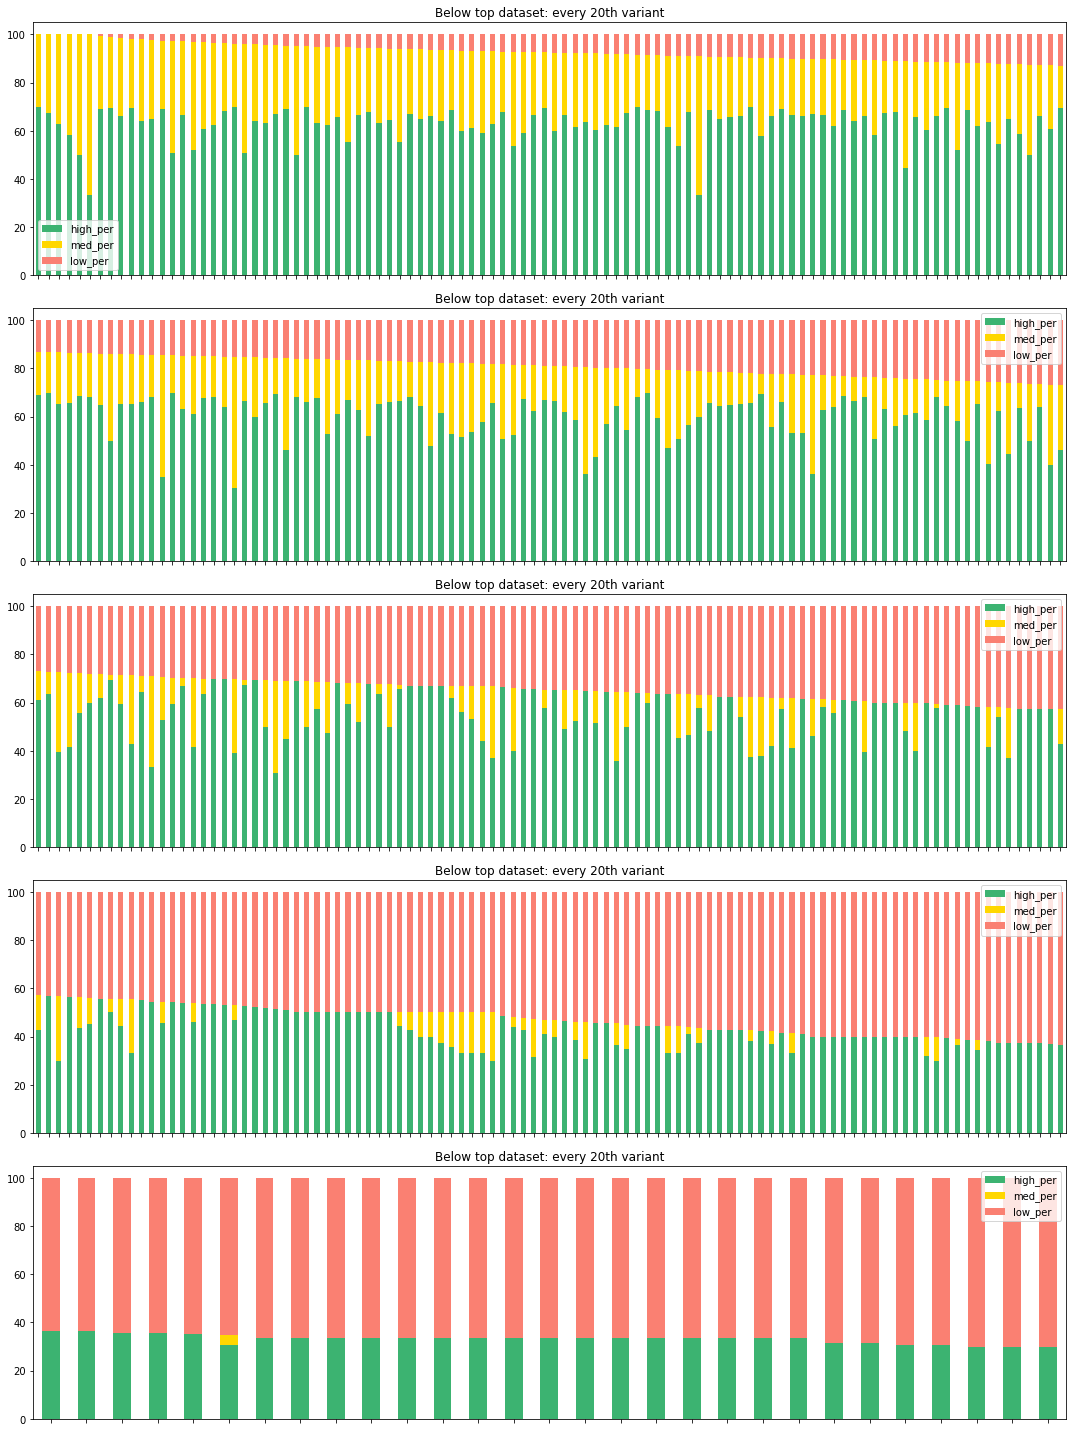

In [38]:
df_plot = df.loc[(df['high_per'] < 70) & (df['high_per'] >=30)].sort_values(by=['low_per', 'med_per', 'high_per'], ascending=True)

#os = 30000
split = 2000
n=5

fig, axes = plt.subplots(n, 1,figsize=(15,4*n))

for p in range(len(axes)):
    df_plot[['high_per', 'med_per', 'low_per']].iloc[p*split:(p+1)*split:20].plot.bar(stacked=True, ax=axes[p], color = cols)
    #df_plot[['high_per', 'med_per', 'low_per']].iloc[os+p*split:os+(p+1)*split:20].plot.bar(stacked=True, ax=axes[p], color = cols)
    
    axes[p].axes.get_xaxis().set_ticklabels([])
    title = 'Below top dataset: every 20th variant'
    axes[p].set_title(title, position=(0.5, 0.9))


plt.tight_layout()

plt.show()

Again, there is no clear cutoff. Still, the variants with <40% reads in the low bin seem to have 50-60% of the reads in the high gate, which is again indicative of strong activity. Thus, define:
- high: 70>x>=30 reads in the high gate, <=40% reads in low gate

In [39]:
df_high = df.loc[(df['high_per'] < 70) & (df['high_per'] >=40) & (df['low_per'] <=40)]

In [40]:
df_high.describe()

,high,med,low-t,Hamming,total_reads,high_per,med_per,low_per
count,5424.000000,5424.000000,5424.000000,5424.000000,5424.000000,5424.000000,5424.000000,5424.000000
mean,55.616519,20.154683,13.242072,5.054019,89.013274,61.020230,19.731430,19.248347
std,42.031534,20.266413,8.942634,0.884556,63.687143,7.270764,11.800995,11.212670
min,4.000000,0.000000,0.000000,0.000000,8.000000,40.000000,0.000000,0.000000
25%,24.000000,5.000000,7.000000,5.000000,41.000000,57.143000,11.753500,9.756000
50%,45.000000,14.000000,12.000000,5.000000,74.000000,62.963000,20.588000,17.647000
75%,78.000000,30.000000,18.000000,6.000000,123.000000,66.667000,28.000000,29.412000
max,340.000000,136.000000,80.000000,6.000000,486.000000,69.963000,60.000000,40.000000


The TopTwo dataset (the most likely active, but more borderline variants) contains 5,717 variants.

Next, let's look at the oppposite end of the distribution and find the very negative variants, building a Bottom dataset.

In [41]:
df_plot = df.loc[df['low_per'] >= 95].sort_values(by=['low_per', 'med_per', 'high_per'], ascending=False)

In [42]:
df_plot.describe()

,high,med,low-t,Hamming,total_reads,high_per,med_per,low_per
count,266628.000000,266628.000000,266628.000000,266628.000000,266628.000000,266628.000000,266628.000000,266628.000000
mean,0.017125,0.034674,14.462498,5.150569,14.514297,0.064847,0.130342,99.804811
std,0.131460,0.186063,9.020841,0.755147,9.097629,0.506922,0.710950,0.866196
min,0.000000,0.000000,3.000000,1.000000,3.000000,0.000000,0.000000,95.000000
25%,0.000000,0.000000,8.000000,5.000000,8.000000,0.000000,0.000000,100.000000
50%,0.000000,0.000000,12.000000,5.000000,12.000000,0.000000,0.000000,100.000000
75%,0.000000,0.000000,19.000000,6.000000,20.000000,0.000000,0.000000,100.000000
max,3.000000,3.000000,95.000000,6.000000,95.000000,5.000000,5.000000,100.000000


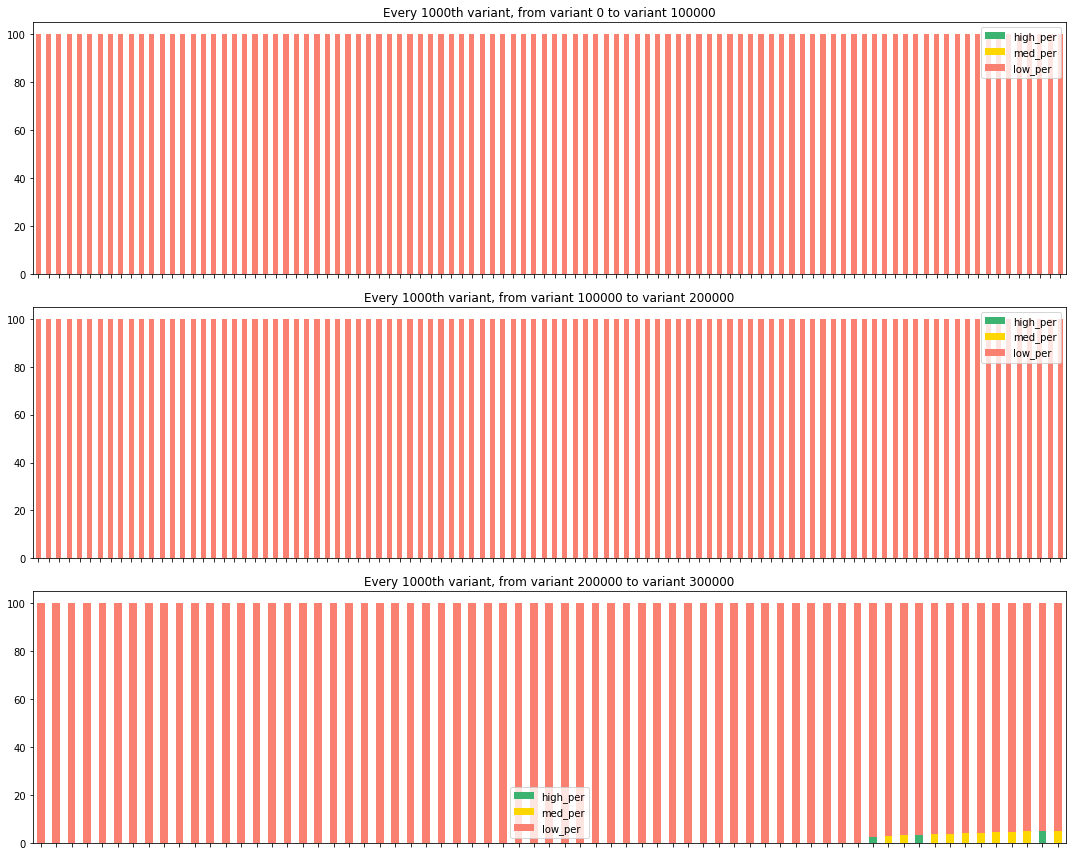

In [43]:
split = 100000
n=3

fig, axes = plt.subplots(n, 1,figsize=(15,4*n))

for p in range(len(axes)):
    df_plot[['high_per', 'med_per', 'low_per']].iloc[p*split:(p+1)*split:1000].plot.bar(stacked=True, ax=axes[p], color = cols)
    axes[p].axes.get_xaxis().set_ticklabels([])
    title = 'Every 1000th variant, from variant ' + str(p*split) + ' to variant ' + str((p+1)*split)
    axes[p].set_title(title, position=(0.5, 0.9))


plt.tight_layout()
#plt.savefig('Read_distribution.png', dpi=300)

plt.show()

In this dataset, we have 266,628 variants that are clearly without activity in this assay (95+ percent reads in the low gate; even the negative control variant has 23% in the medium gate.

In [44]:
ilaa_short = '6P/7aΔ/8aΔ/9A/11A/13P'
df.loc[df['variants'] == ilaa_short]

,high,med,low-t,Hamming,variants,total_reads,high_per,med_per,low_per
209208,0.0,6.0,20.0,2,6P/7aΔ/8aΔ/9A/11A/13P,26.0,0.0,23.077,76.923


In [45]:
df_bottom = df.loc[df['low_per'] >= 95].sort_values(by=['low_per', 'med_per', 'high_per'], ascending=False)

In [46]:
print('All: ', len(df_splimlib))
print('Top: ', len(df_top))
print('High: ', len(df_high))
print('Bottom: ', len(df_bottom))

All:  505957
Top:  30534
High:  5424
Bottom:  266628


Thus, we have 203,078 variants left to classify. These are going to contain the mostly-negative variants (75%-95% low gate, similar to negative control variant), as well as the in-between medium variants.

Next, construct the fourth dataset of mostly-negative variants

In [47]:
df_plot = df.loc[(df['low_per'] >= 75) & (df['low_per'] < 95)].sort_values(by=['low_per', 'med_per', 'high_per'], ascending=False)

In [48]:
len(df_plot)

62816

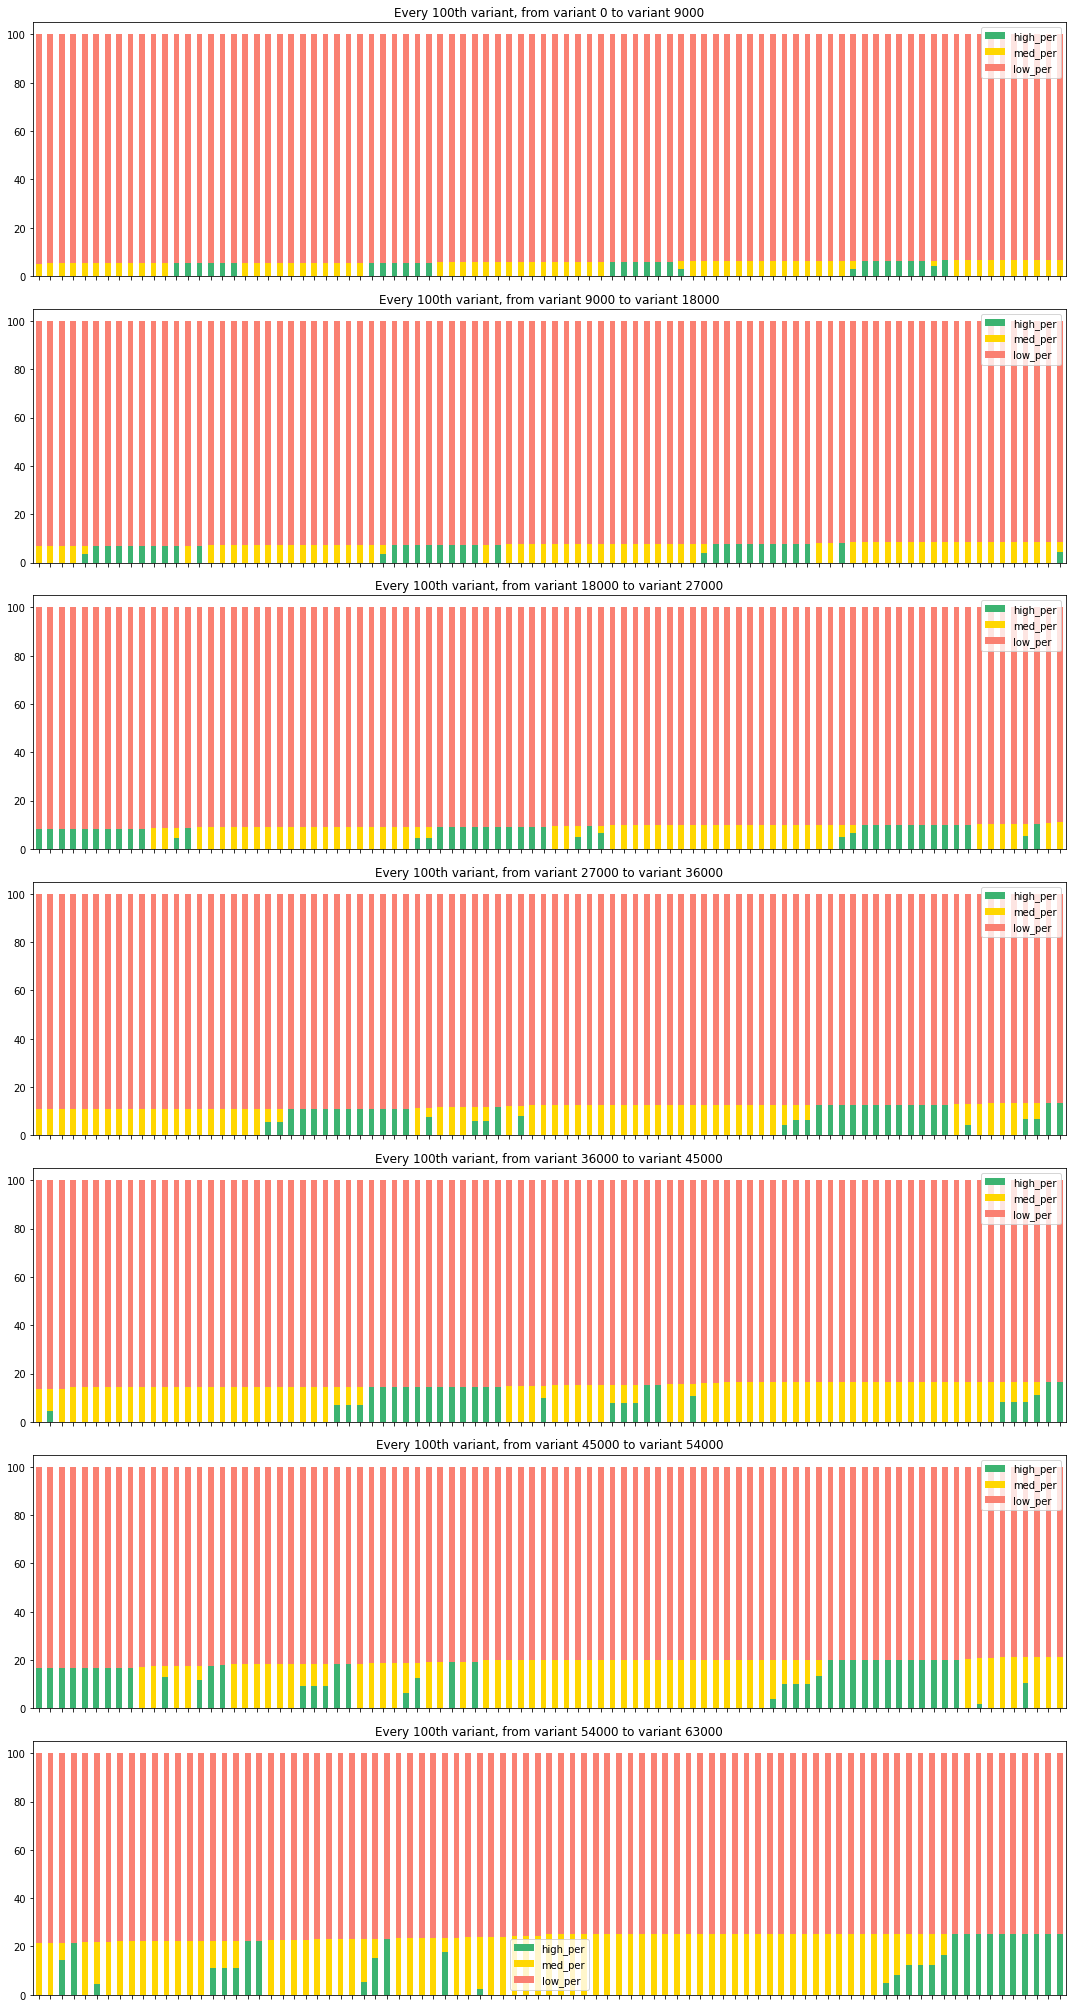

In [49]:
split = 9000
n=7

fig, axes = plt.subplots(n, 1,figsize=(15,4*n))

for p in range(len(axes)):
    df_plot[['high_per', 'med_per', 'low_per']].iloc[p*split:(p+1)*split:100].plot.bar(stacked=True, ax=axes[p], color = cols)
    axes[p].axes.get_xaxis().set_ticklabels([])
    title = 'Every 100th variant, from variant ' + str(p*split) + ' to variant ' + str((p+1)*split)
    axes[p].set_title(title, position=(0.5, 0.9))


plt.tight_layout()
#plt.savefig('Read_distribution.png', dpi=300)

plt.show()

This looks reasonable. Now complete the stratification into five sets by labelling the intermediate variants.

In [50]:
df['set'] = 'medium'

In [51]:
df.loc[df['low_per'] >= 95, 'set'] = 'bottom'
df.loc[(df['low_per'] >= 75) & (df['low_per'] < 95), 'set'] = 'low'
df.loc[df['high_per'] >= 70, 'set'] = 'top'
df.loc[(df['high_per'] < 70) & (df['high_per'] >=40) & (df['low_per'] <=40), 'set'] = 'high'

In [52]:
df['set_numeric'] = 3
df.loc[df['low_per'] >= 95, 'set_numeric'] = 1
df.loc[(df['low_per'] >= 75) & (df['low_per'] < 95), 'set_numeric'] = 2
df.loc[df['high_per'] >= 70, 'set_numeric'] = 5
df.loc[(df['high_per'] < 70) & (df['high_per'] >=40) & (df['low_per'] <=40), 'set_numeric'] = 4

In [53]:
df['set'].describe()

count     505957
unique         5
top       bottom
freq      266628
Name: set, dtype: object

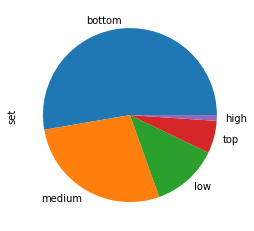

In [54]:
df['set'].value_counts().plot(kind='pie')
plt.show()

### Identify the distribution of single mutants across this distribution

In [55]:
point = df.loc[(df['Hamming'] == 1)].sort_values(by='set_numeric', ascending=False)

In [56]:
print('Top: ', len(point.loc[(point['set'] == 'top')]))
print('High: ', len(point.loc[(point['set'] == 'high')]))
print('Medium: ', len(point.loc[(point['set'] == 'medium')]))
print('Low: ', len(point.loc[(point['set'] == 'low')]))
print('Bottom: ', len(point.loc[(point['set'] == 'bottom')]))
print('All: ', len(point))

Top:  11
High:  3
Medium:  19
Low:  9
Bottom:  11
All:  53


In total, 57 point mutants relative to MKK1 wt sequence are possible; 53 of these have enough sequencing reads in at least one FACS gate.

The WT sequence is in the High set.

In [57]:
point.loc[point['set'] == 'top']

,high,med,low-t,Hamming,variants,total_reads,high_per,med_per,low_per,set,set_numeric
7294,263.0,15.0,3.0,1,6P/7aΔ/8aΔ/9I/11F/13P,281.0,93.594,5.338,1.068,top,5
13214,230.0,12.0,16.0,1,6P/7aΔ/8aΔ/9I/11L/13I,258.0,89.147,4.651,6.202,top,5
13552,136.0,1.0,16.0,1,6P/7aΔ/8aΔ/9P/11L/13P,153.0,88.889,0.654,10.458,top,5
14631,118.0,13.0,3.0,1,6P/7aΔ/8aΔ/9F/11L/13P,134.0,88.060,9.701,2.239,top,5
15880,108.0,1.0,15.0,1,6P/7aΔ/8aΔ/9I/11L/13W,124.0,87.097,0.806,12.097,top,5
17710,83.0,0.0,14.0,1,6I/7aΔ/8aΔ/9I/11L/13P,97.0,85.567,0.000,14.433,top,5
20517,108.0,15.0,7.0,1,6P/7aK/8aΔ/9I/11L/13P,130.0,83.077,11.538,5.385,top,5
22472,173.0,37.0,3.0,1,6P/7aΔ/8aΔ/9I/11L/13L,213.0,81.221,17.371,1.408,top,5
23301,53.0,10.0,3.0,1,6P/7aΔ/8aΔ/9I/11L/13F,66.0,80.303,15.152,4.545,top,5
27999,58.0,19.0,1.0,1,6P/7aΔ/8aΔ/9I/11I/13P,78.0,74.359,24.359,1.282,top,5


The top set contains conservative mutations, largely large hydrophobic residues:
- 6: I (shifting the Φ-X-Φ motif to the start)
- 7a: K (extending the basic pathc) or L (making a L - I - L motif in 7a/9/11)
- 8a: Δ (wt) only, indicating that the A insertion is contingent on other reorganisation
- 9: P or F, both large and hydrophobic
- 11: F or I, both large and hydrophobic
- 13: I, W, L, F, all large and hydrophobic

In [58]:
point.loc[point['set'] == 'high']

,high,med,low-t,Hamming,variants,total_reads,high_per,med_per,low_per,set,set_numeric
32395,102.0,46.0,8.0,1,6P/7aΔ/8aΔ/9I/11M/13P,156.0,65.385,29.487,5.128,high,4
33316,32.0,0.0,19.0,1,6P/7aΔ/8aΔ/9I/11W/13P,51.0,62.745,0.000,37.255,high,4
32080,73.0,24.0,13.0,1,6P/7aΔ/8aΔ/9I/11L/13V,110.0,66.364,21.818,11.818,high,4


In the high set, which also contains WT, we add:
- 11: M, W
- 13: V

In [59]:
point.loc[point['set'] == 'medium']

,high,med,low-t,Hamming,variants,total_reads,high_per,med_per,low_per,set,set_numeric
195348,0.0,6.0,12.0,1,6P/7aΔ/8aΔ/9I/11L/13D,18.0,0.000,33.333,66.667,medium,3
163345,0.0,12.0,11.0,1,6W/7aΔ/8aΔ/9I/11L/13P,23.0,0.000,52.174,47.826,medium,3
156658,0.0,25.0,20.0,1,6G/7aΔ/8aΔ/9I/11L/13P,45.0,0.000,55.556,44.444,medium,3
126146,0.0,14.0,5.0,1,6P/7aΔ/8aA/9I/11L/13P,19.0,0.000,73.684,26.316,medium,3
125785,0.0,17.0,6.0,1,6P/7aΔ/8aΔ/9I/11L/13K,23.0,0.000,73.913,26.087,medium,3
116038,0.0,31.0,7.0,1,6P/7aΔ/8aΔ/9I/11K/13P,38.0,0.000,81.579,18.421,medium,3
98805,1.0,46.0,11.0,1,6A/7aΔ/8aΔ/9I/11L/13P,58.0,1.724,79.310,18.966,medium,3
97795,1.0,35.0,16.0,1,6P/7aΔ/8aΔ/9V/11L/13P,52.0,1.923,67.308,30.769,medium,3
93822,1.0,16.0,22.0,1,6Y/7aΔ/8aΔ/9I/11L/13P,39.0,2.564,41.026,56.410,medium,3
90210,1.0,22.0,10.0,1,6P/7aV/8aΔ/9I/11L/13P,33.0,3.030,66.667,30.303,medium,3


The medium set is the most diverse:
- 6: P + W, G, A, Y, V
- 7a: Δ + V, M
- 8a: Δ + A
- 9: I + V, Y, L, M
- 11: L + K, V
- 13: P + D, K, M, A, G

In [60]:
point.loc[point['set'] == 'low']

,high,med,low-t,Hamming,variants,total_reads,high_per,med_per,low_per,set,set_numeric
65098,2.0,0.0,25.0,1,6P/7aI/8aΔ/9I/11L/13P,27.0,7.407,0.000,92.593,low,2
43847,1.0,0.0,4.0,1,6P/7aΔ/8aΔ/9I/11P/13P,5.0,20.000,0.000,80.000,low,2
224153,0.0,1.0,7.0,1,6P/7aΔ/8aΔ/9I/11L/13Y,8.0,0.000,12.500,87.500,low,2
219042,0.0,2.0,11.0,1,6M/7aΔ/8aΔ/9I/11L/13P,13.0,0.000,15.385,84.615,low,2
44080,6.0,1.0,24.0,1,6L/7aΔ/8aΔ/9I/11L/13P,31.0,19.355,3.226,77.419,low,2
45839,2.0,0.0,10.0,1,6K/7aΔ/8aΔ/9I/11L/13P,12.0,16.667,0.000,83.333,low,2
50276,3.0,0.0,20.0,1,6F/7aΔ/8aΔ/9I/11L/13P,23.0,13.043,0.000,86.957,low,2
57115,1.0,0.0,9.0,1,6D/7aΔ/8aΔ/9I/11L/13P,10.0,10.000,0.000,90.000,low,2
86562,1.0,2.0,25.0,1,6P/7aΔ/8aΔ/9A/11L/13P,28.0,3.571,7.143,89.286,low,2


In the low set we see mostly mutations at the start of the D domain, which disrupt the basic patch at the start, while the hydrophobic core is largely intact:
- 6: M, L, K, F, D
- 7a: I
- 8a: 
- 9: A
- 11: P
- 13: Y

In [61]:
point.loc[point['set'] == 'bottom']

,high,med,low-t,Hamming,variants,total_reads,high_per,med_per,low_per,set,set_numeric
250001,0.0,1.0,28.0,1,6P/7aP/8aΔ/9I/11L/13P,29.0,0.0,3.448,96.552,bottom,1
345046,0.0,0.0,15.0,1,6P/7aΔ/8aΔ/9D/11L/13P,15.0,0.0,0.000,100.000,bottom,1
351558,0.0,0.0,14.0,1,6P/7aΔ/8aΔ/9I/11A/13P,14.0,0.0,0.000,100.000,bottom,1
354190,0.0,0.0,14.0,1,6P/7aG/8aΔ/9I/11L/13P,14.0,0.0,0.000,100.000,bottom,1
408173,0.0,0.0,10.0,1,6P/7aΔ/8aΔ/9I/11D/13P,10.0,0.0,0.000,100.000,bottom,1
417003,0.0,0.0,9.0,1,6P/7aD/8aΔ/9I/11L/13P,9.0,0.0,0.000,100.000,bottom,1
443541,0.0,0.0,7.0,1,6P/7aΔ/8aΔ/9G/11L/13P,7.0,0.0,0.000,100.000,bottom,1
456889,0.0,0.0,6.0,1,6P/7aΔ/8aΔ/9K/11L/13P,6.0,0.0,0.000,100.000,bottom,1
470031,0.0,0.0,5.0,1,6P/7aF/8aΔ/9I/11L/13P,5.0,0.0,0.000,100.000,bottom,1
493399,0.0,0.0,4.0,1,6P/7aΔ/8aΔ/9I/11G/13P,4.0,0.0,0.000,100.000,bottom,1


The bottom set introduces small or charged amino acids at the three positions that make the core of the Φ-X-Φ motif:
- 6: 
- 7a: P, G, D, F
- 8a: 
- 9: D, G, K, W
- 11: A, D, G
- 13: 

In [62]:
df.head()

,high,med,low-t,Hamming,variants,total_reads,high_per,med_per,low_per,set,set_numeric
0,537.0,0.0,0.0,6,6V/7aP/8aA/9F/11V/13W,537.0,100.0,0.0,0.0,top,5
1,524.0,0.0,0.0,6,6V/7aP/8aA/9F/11I/13W,524.0,100.0,0.0,0.0,top,5
2,480.0,0.0,0.0,6,6K/7aI/8aA/9L/11I/13K,480.0,100.0,0.0,0.0,top,5
3,456.0,0.0,0.0,5,6A/7aL/8aΔ/9F/11I/13V,456.0,100.0,0.0,0.0,top,5
4,449.0,0.0,0.0,6,6F/7aI/8aA/9L/11I/13M,449.0,100.0,0.0,0.0,top,5


In [63]:
df.to_csv('splimlib.zip')    